In [1]:
import time
import pickle
import numpy as np
import networkx as nx
import queue
import matplotlib.pyplot as plt

from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection
import itertools

from cutqc.main import CutQC
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit import ControlledGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm

import cutDQVA as dqva

In [2]:
def get_cut_solution(cutqc, max_subcirc_qubit):
    circname = list(cutqc.circuits.keys())[0]
    subcirc_file = 'cutqc_data/' + circname + '/cc_{}/subcircuits.pckl'.format(max_subcirc_qubit)
    picklefile = open(subcirc_file, 'rb')
    cut_solution = pickle.load(picklefile)
    return cut_solution

def cut_and_print(circ, max_subcircuit_qubit, num_subcircuits, max_cuts):
    circuits = {'my_circ':circ}
    cutqc = CutQC(circuits=circuits, max_subcircuit_qubit=max_subcircuit_qubit,
                  num_subcircuits=num_subcircuits, max_cuts=max_cuts, verbose=1)
    cutsoln = get_cut_solution(cutqc, max_subcircuit_qubit)
    print('Complete Path Map:')
    
    wpm = {}
    for key in cutsoln['complete_path_map']:
        print(key, '->', cutsoln['complete_path_map'][key])
        temp = []
        for frag_qubit in cutsoln['complete_path_map'][key]:
            temp.append((frag_qubit['subcircuit_idx'], frag_qubit['subcircuit_qubit']))
        wpm[key] = tuple(temp)
        
    print('positions:', cutsoln['positions'])
    for i, sc in enumerate(cutsoln['subcircuits']):
        print('Subcirc', i)
        print('\tqubits = {}, gate counts = {}'.format(len(sc.qubits), sc.count_ops()))
        print(sc.draw(fold=200))
    
    return cutsoln['subcircuits'], wpm

In [3]:
def fidelity(dist, actual_dist):
    fidelity = sum( np.sqrt(actual_dist[bits] * dist[bits], dtype = complex)
                    for bits in all_bits
                    if actual_dist.get(bits) and dist.get(bits) )**2
    return fidelity.real if fidelity.imag == 0 else fidelity

def naive_fix(dist):
    norm = sum( value for value in dist.values() if value >= 0 )
    return { bits : value / norm for bits, value in dist.items() if value >= 0 }

## Start with a simple example
The goal is to convert the cutQC `complete_path_map` to the QSPLIT `wire_path_map`

In [40]:
nq = 3
ghz_circ = QuantumCircuit(nq, name='q')
for i in range(nq):
    ghz_circ.rz(i, i)
ghz_circ.h(0)
for i in range(nq-1):
    ghz_circ.cx(i, i+1)
for i in range(nq):
    ghz_circ.rz(i, i)
ghz_circ.draw(fold=-1)

┌───────┐┌───┐     ┌───────┐         
q_0: ┤ RZ(0) ├┤ H ├──■──┤ RZ(0) ├─────────
     ├───────┤└───┘┌─┴─┐└───────┘┌───────┐
q_1: ┤ RZ(1) ├─────┤ X ├────■────┤ RZ(1) ├
     ├───────┤     └───┘  ┌─┴─┐  ├───────┤
q_2: ┤ RZ(2) ├────────────┤ X ├──┤ RZ(2) ├
     └───────┘            └───┘  └───────┘

In [41]:
subcircs, wpm = cut_and_print(ghz_circ, 2, [2], 1)

-------------------- Cut --------------------
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
my_circ : 1 cuts --> {0: {'effective': 1, 'rho': 0, 'O': 1, 'd': 2}, 1: {'effective': 2, 'rho': 1, 'O': 0, 'd': 2}}
Complete Path Map:
Qubit(QuantumRegister(3, 'q'), 0) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}]
Qubit(QuantumRegister(3, 'q'), 1) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}]
Qubit(QuantumRegister(3, 'q'), 2) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}]
positions: [(Qubit(QuantumRegister(3, 'q'), 1), 1)]
Subcirc 0
	qubits = 2, gate counts = OrderedDict([('rz', 3), ('h', 1), ('cx', 1)])
     ┌───────┐┌───┐     ┌───────┐
q_0: ┤ RZ(0) ├┤ H ├──■──┤ RZ(0) ├
     ├───────┤└───┘┌─┴─┐└───────┘
q_1: ┤ RZ(1) ├─────┤ X ├─────────
     └───────┘     └───┘       

Process ForkPoolWorker-85:
Process ForkPoolWorker-94:
Process ForkPoolWorker-90:
Process ForkPoolWorker-91:
Process ForkPoolWorker-86:
Process ForkPoolWorker-92:
Process ForkPoolWorker-96:
Process ForkPoolWorker-88:
Process ForkPoolWorker-87:
Process ForkPoolWorker-89:
Process ForkPoolWorker-95:
Traceback (most recent call last):
Process ForkPoolWorker-93:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/teague/anaconda3/envs/cutEnv/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  Fi

In [42]:
print(subcircs)

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f871ab2cd50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f871ab2ced0>]


In [43]:
print(wpm)

{Qubit(QuantumRegister(3, 'q'), 0): ((0, Qubit(QuantumRegister(2, 'q'), 0)),), Qubit(QuantumRegister(3, 'q'), 1): ((0, Qubit(QuantumRegister(2, 'q'), 1)), (1, Qubit(QuantumRegister(2, 'q'), 0))), Qubit(QuantumRegister(3, 'q'), 2): ((1, Qubit(QuantumRegister(2, 'q'), 1)),)}


In [44]:
shots = 999999
total_variants = 7
simulation_backend = 'qasm_simulator'
frag_data = qmm.collect_fragment_data(subcircs, wpm, shots=shots // total_variants,
                                      tomography_backend=simulation_backend)
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wpm)

In [45]:
direct_recombined_dist = naive_fix(direct_recombined_dist)

In [46]:
all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = nq) ]

actual_state = qmm.get_statevector(ghz_circ)
actual_dist = { "".join(bits) : abs(amp)**2 for bits, amp in zip(all_bits, actual_state) if amp != 0 }

In [47]:
direct_fidelity = fidelity(direct_recombined_dist, actual_dist)
likely_fidelity = fidelity(likely_recombined_dist, actual_dist)

In [48]:
print("actual probability distribution:")
for bits in all_bits:
    try: print(bits, actual_dist[bits])
    except : None

print()
print("'direct' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, direct_recombined_dist[bits])
    except : None

print()
print("'likely' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, likely_recombined_dist[bits])
    except : None

print()
print("'direct' distribution fidelity:", direct_fidelity)
print("'likely' distribution fidelity:", likely_fidelity)

actual probability distribution:
000 0.5000000000000001
111 0.4999999999999999

'direct' recombined probability distribution:
000 0.5002574511976233
001 0.0006484252207286543
111 0.4990941235816479

'likely' recombined probability distribution:
000 0.5003146534273529
001 0.0005345771626856069
110 8.38695807444072e-09
111 0.4991507610230034

'direct' distribution fidelity: 0.9993512362268452
'likely' distribution fidelity: 0.9994650756077187


### NOTE:
The QSPLIT-MLFT adds a small amount of noise to the circuit execution. This can be accounted for within the DQVA algorithm by postprocessing the 
resulting bitstrings and checking that they are valid MIS

## Cut, evalutate, and reconstruct a DQV Ansatz

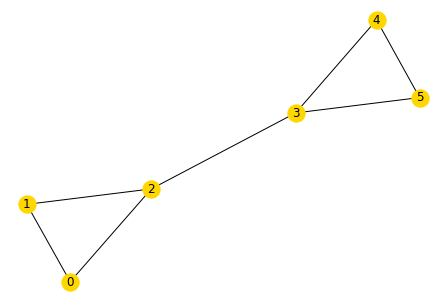

In [4]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (3, 5), (4,5)])
nx.draw_spring(G, with_labels=True, node_color='gold')
nq = len(G.nodes())

In [5]:
kl_bisection = ({3, 4, 5}, {0, 1, 2})
params = list(range(1, 2*nq+1+1))
print(params)
cur_init_state = '0'*nq
cur_permutation = list(range(nq))
dqv_circ = dqva.gen_dqva(G, kl_bisection, params=params, init_state=cur_init_state, cut=True,
                         mixer_order=cur_permutation, verbose=1, decompose_toffoli=2,
                         barriers=0, hot_nodes=[2])
print(dqv_circ.count_ops())
dqv_circ.draw(fold=-1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Current partition: ({3, 4, 5}, {0, 1, 2})
subgraphs: [[3, 4, 5], [0, 1, 2]]
cutedges: [(2, 3)]
hot nodes: [2]
Qubit 3 is cold! Apply Identity mixer
qubit: 4 num_qubits = 8 neighbors: [3, 5]
qubit: 5 num_qubits = 8 neighbors: [3, 4]
qubit: 0 num_qubits = 8 neighbors: [1, 2]
qubit: 1 num_qubits = 8 neighbors: [0, 2]
qubit: 2 num_qubits = 8 neighbors: [0, 1, 3]
Qubit 3 is cold! Apply Identity mixer
qubit: 4 num_qubits = 8 neighbors: [3, 5]
qubit: 5 num_qubits = 8 neighbors: [3, 4]
qubit: 0 num_qubits = 8 neighbors: [1, 2]
qubit: 1 num_qubits = 8 neighbors: [0, 2]
qubit: 2 num_qubits = 8 neighbors: [0, 1, 3]
OrderedDict([('cx', 176), ('x', 88), ('u1', 84), ('t', 64), ('tdg', 48), ('h', 40), ('crx', 10), ('rz', 6)])


┌───────┐┌───┐                                                                                                                                                                        ┌───┐          ┌───┐  ┌───┐                                                                            ┌───┐              ┌───┐   ┌───┐                                                                                                             ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                                    ┌───┐   ┌───┐                                                                                                                                     ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                             ┌───┐    ┌─────────┐                              ┌───┐   ┌────────┐                                                                                               ┌────────┐┌───┐                                                                                                                                                                           ┌───┐        ┌───┐    ┌───┐                                                                      ┌───┐      ┌───┐   ┌───┐                                                                                                     ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                                    ┌───┐   ┌───┐                                                                                                                                 ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐   ┌──────────┐                        ┌───┐    ┌─────────┐                         ┌───┐        
  q_0: ───────────────────────────────────────────────────────────────────────────────────────────┤ RX(2) ├┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────■──────■───────┤ T ├─────■────┤ X ├──┤ X ├───────────────────────────────■───────────────────────────────────■────■───┤ T ├─────■────────┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■───────────────────────────■─────┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) ├──■────────────────────■─────┤ X ├────┤ U1(π/8) ├──■─────────────────────■─────┤ X ├───┤ RZ(14) ├───────────────────────────────────────────────────────────────────────────────────────────────┤ RX(16) ├┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────■────■───┤ T ├───■────┤ X ├────┤ X ├──────────────────────────────■──────────────────────────────■────■───┤ T ├───■──┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■───────────────────────────■─────┤ X ├───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ U1(-π/8) ├──■───────────────■─────┤ X ├────┤ U1(π/8) ├──■────────────────■─────┤ X ├───┤ U1(-π/8) 

In [6]:
subcircs, wpm = cut_and_print(dqv_circ, nq, [2], 3)

-------------------- Cut --------------------
Using license file /Users/teague/gurobi.lic
Academic license - for non-commercial use only
my_circ : 3 cuts --> {0: {'effective': 3, 'rho': 1, 'O': 2, 'd': 5}, 1: {'effective': 5, 'rho': 2, 'O': 1, 'd': 6}}
Complete Path Map:
Qubit(QuantumRegister(6, 'q'), 0) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 0)}]
Qubit(QuantumRegister(6, 'q'), 1) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 1)}]
Qubit(QuantumRegister(6, 'q'), 2) -> [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 2)}]
Qubit(QuantumRegister(6, 'q'), 3) -> [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(5, 'q'), 0)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 3)}, {'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(5, 'q'), 1)}, {'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(6, 'q'), 4)}]
Qubit(QuantumRegister(6, 'q'),

In [23]:
shots = 999999
total_variants = 7
simulation_backend = 'qasm_simulator'
frag_data = qmm.collect_fragment_data(subcircs, wpm, shots=15000, tomography_backend=simulation_backend)
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

direct_recombined_dist = qmm.recombine_fragment_models(direct_models, wpm)
likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wpm)

In [24]:
direct_recombined_dist = naive_fix(direct_recombined_dist)

In [25]:
all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = len(dqv_circ.qubits)) ]

actual_state = qmm.get_statevector(dqv_circ)
actual_dist = { "".join(bits) : abs(amp)**2 for bits, amp in zip(all_bits, actual_state) if amp != 0 }

In [26]:
direct_fidelity = fidelity(direct_recombined_dist, actual_dist)
likely_fidelity = fidelity(likely_recombined_dist, actual_dist)

In [27]:
print("actual probability distribution:")
for bits in all_bits:
    try: print(bits, actual_dist[bits])
    except : None

print()
print("'direct' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, direct_recombined_dist[bits])
    except : None

print()
print("'likely' recombined probability distribution:")
for bits in all_bits:
    try: print(bits, likely_recombined_dist[bits])
    except : None

print()
print("'direct' distribution fidelity:", direct_fidelity)
print("'likely' distribution fidelity:", likely_fidelity)

actual probability distribution:
00000000 0.04921153618961752
00000001 0.01160385680870136
00000010 0.12992585142939095
00000011 1.168382263079011e-34
00000100 0.01604245166526137
00000101 3.4681576360945495e-35
00000110 5.627012390416527e-36
00000111 3.0258419576275745e-65
00010000 0.16861041945780764
00010001 0.039757571401647464
00010010 0.4451568474414799
00010011 5.513958829485576e-36
00010100 0.05496525233410613
00010101 9.756812489799399e-35
00010110 3.3581398422026406e-35
00010111 6.2375250711182815e-65
00100000 0.02016361632673593
00100001 0.004754489185208567
00100010 0.053234977446191656
00100011 2.061886934593207e-35
00100100 0.006573130313838513
00100101 3.291630664558381e-36
00100110 4.972510388444487e-36
00100111 3.235833100153426e-67
00110000 8.493149646245688e-34
00110001 8.64943643553755e-34
00110010 1.558008812000475e-33
00110011 3.088881222942004e-66
00110100 8.273030927437986e-34
00110101 1.587896688666005e-36
00110110 2.5914910404170474e-36
00110111 1.985210605926